In [1]:
customer_id = 1

# ALL CODE

## 0. Importing and key parameters

In [2]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt

In [3]:
# Hyperparameters needed for a run:

# Data fetching
locations_used = 1
start_date = 2005
end_date = 2013

# Forecasting parameters
day_only = False
features = ['P']
final_month = 12
split = 0.8

# Lstm parameters
hidden_size = 400
num_layers = 3
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 200
batch_size = 32
learning_rate = 0.0001

## 1. Target location

In [4]:
data_aus = pd.read_parquet('../data/australia/aus_production.parquet', engine='pyarrow')
data_aus = data_aus[data_aus['Customer'] == customer_id]
data_aus

,Customer,Postcode,Generator Capacity,Values,latitude,longitude
date,,,,,,
2011-07-01 00:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 00:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 02:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
...,...,...,...,...,...,...
2013-06-30 21:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078


In [5]:
# Hyperparams from the data
peak_power = data_aus['Generator Capacity'].iloc[0]
latitude = data_aus['latitude'].iloc[0]
longitude = data_aus['longitude'].iloc[0]

# Hyperparams not included in the data
tilt = 0
azimuth = 0
optimalangles = True

latitude, longitude, peak_power, tilt, azimuth

(-33.69699153381296, 151.13077966206853, 3.78, 0, 0)

In [6]:
# Unique name for the data, model and metrics
data_name = 'australia' '_' + str(customer_id)
data_name

'australia_1'

In [7]:
# Create the folders to save the data and models
data_folder = '../data/AUS/'
model_folder = '../models/AUS/' + data_name
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [8]:
data_aus = pd.DataFrame(data_aus['Values'])
data_aus = data_aus.resample('H').sum()
data_aus = data_aus.rename(columns={"Values":"P"})

target_data = data_aus
target_data

,P
date,
2011-07-01 00:00:00,0.0
2011-07-01 01:00:00,0.0
2011-07-01 02:00:00,0.0
2011-07-01 03:00:00,0.0
2011-07-01 04:00:00,0.0
...,...
2013-06-30 19:00:00,0.0
2013-06-30 20:00:00,0.0
2013-06-30 21:00:00,0.0


## 2. Source location

In [9]:
# Import the datafetcher class
from src.data.datafetcher import DataFetcher

# Fetch data from PVGIS
data_PVGIS = DataFetcher(latitude,longitude,peak_power, tilt, azimuth, locations=locations_used, start_date=start_date, end_date=end_date,optimal_angles=1)

# Save the data in the data folder
#path = data.save_data(file_name = data_name + '/' + data_name)
#path

Gathering data from base location...


In [10]:
data =[]
data.append(data_PVGIS.dataset[0])

In [11]:
# Import the featurisation class
from src.data.featurisation import Featurisation

# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
#dataset = Featurisation(data.dataset).base_features(features)
dataset = Featurisation(data).base_features(features)

# Use cyclic features as well
dataset = Featurisation(dataset).cyclic_features(yearly=True)
features = dataset[0].columns # update the features
dataset[0].head()

C:\Users\jdepoort\OneDrive - KU Leuven\Projects\DONE - SolNet\SolNet\src\data\featurisation.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[i]['hour_sin'] = np.sin(2 * np.pi * self.data[i].index.hour / 24)
C:\Users\jdepoort\OneDrive - KU Leuven\Projects\DONE - SolNet\SolNet\src\data\featurisation.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[i]['hour_cos'] = np.cos(2 * np.pi * self.data[i].index.hour / 24)
C:\Users\jdepoort\OneDrive - KU Leuven\Projects\DONE - SolNet\SolNet\s

,P,hour_sin,hour_cos,month_sin,month_cos
time,,,,,
2005-01-01 00:00:00,2579.70,0.000000,1.000000,0.5,0.866025
2005-01-01 01:00:00,2544.70,0.258819,0.965926,0.5,0.866025
2005-01-01 02:00:00,2516.23,0.500000,0.866025,0.5,0.866025
2005-01-01 03:00:00,2478.21,0.707107,0.707107,0.5,0.866025
2005-01-01 04:00:00,2052.35,0.866025,0.500000,0.5,0.866025


In [12]:
from src.util import daytime

In [13]:
if day_only is True:
    dataset, removed_hours, kept_hours = daytime.remove_nighttime(dataset)
    lags = len(kept_hours)
    forecast_period = len(kept_hours)
    removed_hours, kept_hours
else:
    lags = 24
    forecast_period = 24

In [14]:
domain_min = [0.0]
domain_max = [peak_power*0.86]
for i in range(len(features[1:])):
    domain_min.append(min(dataset[0][features[i+1]]))
    domain_max.append(max(dataset[0][features[i+1]]))

In [15]:
dataset[0] = dataset[0].tz_localize('UTC').tz_convert('Australia/Sydney').tz_localize(None)
dataset[0] = dataset[0][13:]

## 3. Target featurisation

In [16]:
# Remove nighttime
if day_only is True:
    data_aus = data_aus[~data_aus.index.hour.isin(removed_hours)]

In [17]:
start = data_aus.index[0]
end = dataset[0].index[-1]

In [18]:
# We use the features of dataset[0] because this is the base location, and is identical to the target location
features_nl = dataset[0][features[1:]].loc[start:end]
features_nl.head()

,hour_sin,hour_cos,month_sin,month_cos
time,,,,
2011-07-01 00:00:00,-0.500000,-8.660254e-01,1.224647e-16,-1.0
2011-07-01 01:00:00,-0.707107,-7.071068e-01,1.224647e-16,-1.0
2011-07-01 02:00:00,-0.866025,-5.000000e-01,1.224647e-16,-1.0
2011-07-01 03:00:00,-0.965926,-2.588190e-01,1.224647e-16,-1.0
2011-07-01 04:00:00,-1.000000,-1.836970e-16,1.224647e-16,-1.0


In [19]:
target_data = pd.merge(data_aus.loc[start:end], features_nl, left_index=True, right_index=True)
target_data = target_data.loc[~target_data.index.duplicated(keep='first')]
target_data = target_data.resample('H').asfreq() # Add the missing values from summer time
target_data = target_data.interpolate(method='linear')

target_data

,P,hour_sin,hour_cos,month_sin,month_cos
2011-07-01 00:00:00,0.0,-5.000000e-01,-8.660254e-01,1.224647e-16,-1.0
2011-07-01 01:00:00,0.0,-7.071068e-01,-7.071068e-01,1.224647e-16,-1.0
2011-07-01 02:00:00,0.0,-8.660254e-01,-5.000000e-01,1.224647e-16,-1.0
2011-07-01 03:00:00,0.0,-9.659258e-01,-2.588190e-01,1.224647e-16,-1.0
2011-07-01 04:00:00,0.0,-1.000000e+00,-1.836970e-16,1.224647e-16,-1.0
...,...,...,...,...,...
2013-06-30 19:00:00,0.0,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0
2013-06-30 20:00:00,0.0,5.000000e-01,-8.660254e-01,1.224647e-16,-1.0
2013-06-30 21:00:00,0.0,2.588190e-01,-9.659258e-01,1.224647e-16,-1.0
2013-06-30 22:00:00,0.0,1.224647e-16,-1.000000e+00,1.224647e-16,-1.0


In [20]:
dataset[0] = dataset[0][dataset[0].index.year < target_data.index.year[0]]
dataset[0] = dataset[0].loc[~dataset[0].index.duplicated(keep='first')]
dataset[0] = dataset[0].resample('H').asfreq() # Add the missing values from summer time
dataset[0] = dataset[0].interpolate(method='linear')
dataset[0]

,P,hour_sin,hour_cos,month_sin,month_cos
time,,,,,
2005-01-02 00:00:00,0.00,-2.588190e-01,-0.965926,5.000000e-01,0.866025
2005-01-02 01:00:00,0.00,-5.000000e-01,-0.866025,5.000000e-01,0.866025
2005-01-02 02:00:00,0.00,-7.071068e-01,-0.707107,5.000000e-01,0.866025
2005-01-02 03:00:00,0.00,-8.660254e-01,-0.500000,5.000000e-01,0.866025
2005-01-02 04:00:00,0.00,-9.659258e-01,-0.258819,5.000000e-01,0.866025
...,...,...,...,...,...
2010-12-31 19:00:00,50.95,8.660254e-01,-0.500000,-2.449294e-16,1.000000
2010-12-31 20:00:00,0.00,7.071068e-01,-0.707107,-2.449294e-16,1.000000
2010-12-31 21:00:00,0.00,5.000000e-01,-0.866025,-2.449294e-16,1.000000


## 4. Create tensors of the data

### 4.1 Source data

In [21]:
# Import the tensorisation class to transform the data into tensors for use in pytorch models
from src.tensors.tensorisation import Tensorisation
import torch

# Get the list of features
features = list(dataset[0].columns)

# Get the tensors
X_train_source = torch.empty(0, dtype=torch.float32)
X_test_source = torch.empty(0, dtype=torch.float32)
y_train_source = torch.empty(0, dtype=torch.float32)
y_test_source = torch.empty(0, dtype=torch.float32)

for i in range(len(dataset)):
    tensors = Tensorisation(dataset[i], 'P', features, lags, forecast_period)
    X_train, X_test, y_train, y_test = tensors.tensor_creation()
    X_train_source = torch.concat([X_train_source, X_train])
    X_test_source = torch.concat([X_test_source, X_test])
    y_train_source = torch.concat([y_train_source, y_train])
    y_test_source = torch.concat([y_test_source, y_test])
    
X_train_source.shape, X_test_source.shape, y_train_source.shape, y_test_source.shape

C:\Users\jdepoort\OneDrive - KU Leuven\Projects\DONE - SolNet\SolNet\src\tensors\tensorisation.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature]).type(torch.float32)


(torch.Size([1751, 24, 5]),
 torch.Size([438, 24, 5]),
 torch.Size([1751, 24, 1]),
 torch.Size([438, 24, 1]))

### 4.2 Target data

In [22]:
training_months = list(target_data[target_data.index.year == (target_data.index.year[-1]-1)].index.month.unique())

In [23]:
# Set the end of the month

training_months_copy = training_months.copy()

for month in training_months_copy:
    if month > final_month:
        training_months.remove(month)

In [24]:
train_starts = []
for i in range(len(training_months)):
    train_start = target_data[(target_data.index.year == (target_data.index.year[-1]-1)) & (target_data.index.month ==training_months[i])].index[0]
    train_starts.append(train_start)
    
train_starts = list(reversed(train_starts))

In [25]:
model_data_end = target_data[(target_data.index.year == (target_data.index.year[-1]-1)) & (target_data.index.month ==final_month)].index[-1]
model_data_end

Timestamp('2012-12-31 23:00:00')

In [26]:
X_train_target_list = []
X_test_target_list = []
X_eval_target_list = []
y_train_target_list = []
y_test_target_list = []
y_eval_target_list = []

for i in range(len(training_months)):     
    tensors = Tensorisation(target_data[train_starts[i]:model_data_end], 'P', features, lags, forecast_period,train_test_split = split, domain_min=domain_min, domain_max=domain_max)
    eval_tensors = Tensorisation(target_data, 'P', features, lags, forecast_period,domain_min=domain_min, domain_max=domain_max)
    X_train_target, X_test_target, y_train_target, y_test_target = tensors.tensor_creation()
    _, _, _, _, X_eval_target, y_eval_target = eval_tensors.tensor_creation_with_evaluation(len(target_data[(target_data.index >= '2012-07-01')]))
    X_train_target_list.append(X_train_target)
    X_test_target_list.append(X_test_target)
    X_eval_target_list.append(X_eval_target)
    y_train_target_list.append(y_train_target)
    y_test_target_list.append(y_test_target)
    y_eval_target_list.append(y_eval_target) 
    
    print(X_train_target.shape, X_test_target.shape, X_eval_target.shape, y_train_target.shape, y_test_target.shape, y_eval_target.shape)

C:\Users\jdepoort\OneDrive - KU Leuven\Projects\DONE - SolNet\SolNet\src\tensors\tensorisation.py:153: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature][:-evaluation_length]).type(torch.float32)
C:\Users\jdepoort\OneDrive - KU Leuven\Projects\DONE - SolNet\SolNet\src\tensors\tensorisation.py:154: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor_eval = torch.tensor(self.data[feature][-evaluation_length:]).type(torch.float32)


torch.Size([24, 24, 5]) torch.Size([6, 24, 5]) torch.Size([364, 24, 5]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1]) torch.Size([364, 24, 1])
torch.Size([48, 24, 5]) torch.Size([12, 24, 5]) torch.Size([364, 24, 5]) torch.Size([48, 24, 1]) torch.Size([12, 24, 1]) torch.Size([364, 24, 1])
torch.Size([73, 24, 5]) torch.Size([18, 24, 5]) torch.Size([364, 24, 5]) torch.Size([73, 24, 1]) torch.Size([18, 24, 1]) torch.Size([364, 24, 1])
torch.Size([97, 24, 5]) torch.Size([24, 24, 5]) torch.Size([364, 24, 5]) torch.Size([97, 24, 1]) torch.Size([24, 24, 1]) torch.Size([364, 24, 1])
torch.Size([122, 24, 5]) torch.Size([30, 24, 5]) torch.Size([364, 24, 5]) torch.Size([122, 24, 1]) torch.Size([30, 24, 1]) torch.Size([364, 24, 1])
torch.Size([146, 24, 5]) torch.Size([37, 24, 5]) torch.Size([364, 24, 5]) torch.Size([146, 24, 1]) torch.Size([37, 24, 1]) torch.Size([364, 24, 1])
torch.Size([170, 24, 5]) torch.Size([43, 24, 5]) torch.Size([364, 24, 5]) torch.Size([170, 24, 1]) torch.Size([43, 24, 1])

## 5. Source model

In [27]:
# Import the lstm class to create an untrained LSTM
from src.models.lstm import LSTM

# Set the parameters for the lstm
input_size = len(features)

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(5, 400, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=400, out_features=24, bias=True)
)

Step 0: Average train loss: 0.0064 | Average test loss: 0.0093
Step 5: Average train loss: 0.0063 | Average test loss: 0.0096
Step 10: Average train loss: 0.0063 | Average test loss: 0.0096
Step 15: Average train loss: 0.0063 | Average test loss: 0.0097
Step 20: Average train loss: 0.0063 | Average test loss: 0.0096
Step 25: Average train loss: 0.0063 | Average test loss: 0.0094
Step 30: Average train loss: 0.0063 | Average test loss: 0.0096
Step 35: Average train loss: 0.0063 | Average test loss: 0.0094
Step 40: Average train loss: 0.0063 | Average test loss: 0.0096
Step 45: Average train loss: 0.0062 | Average test loss: 0.0095
Step 50: Average train loss: 0.0063 | Average test loss: 0.0098
Step 55: Average train loss: 0.0062 | Average test loss: 0.0093
Step 60: Average train loss: 0.0061 | Average test loss: 0.0093
Step 65: Average train loss: 0.0062 | Average test loss: 0.0092
Step 70: Average train loss: 0.0062 | Average test loss: 0.0093
Step 75: Average train loss: 0.0062 | Aver

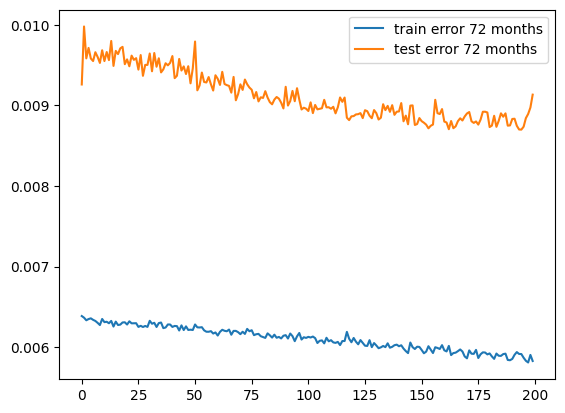

In [31]:
# Import the training class to train the model
import src.models.training as train
 
# Initialize the trainer
training = train.Training(my_lstm, X_train_source, y_train_source, X_test_source, y_test_source, epochs,batch_size=batch_size, learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

In [32]:
# Load the state dictionary of the best performing model
my_lstm.load_state_dict(state_dict_list[best_epoch])

# Save the model state dictionary for later use 
train.save_model(my_lstm, 'AUS/' + data_name + '/model_' + data_name + '_transfer_0')

In [33]:
# Forecast with the model
forecasts = my_lstm(X_test_source.to(device))

In [34]:
# Import the evaluation script
from src.evaluation.evaluation import Evaluation

# Evaluate the model performance
source_eval = Evaluation(y_test_source.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# Show the evaluation metrics
source_eval.metrics()

,MSE,Var(x),Var(y),Corr,Bias,Conditional bias 1,Resolution,Conditional bias 2,Discrimination
Metrics,0.095,0.059,0.058,0.924,0.000,0.009,0.059,0.009,0.059


## 6. Target model

In [35]:
# Set the parameters for the lstm
input_size = len(features)

# Create empty models for each of the periods
lstms = []

for i in range(len(training_months)+1):
    lstms.append(LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device))
    
torch.save(lstms[0].state_dict(), '../models/AUS/' + data_name + '/model_' + data_name + '_target_0')

Step 0: Average train loss: 0.1389 | Average test loss: 0.1674
Step 5: Average train loss: 0.1297 | Average test loss: 0.1568
Step 10: Average train loss: 0.1197 | Average test loss: 0.1443
Step 15: Average train loss: 0.1055 | Average test loss: 0.1259
Step 20: Average train loss: 0.0816 | Average test loss: 0.0915
Step 25: Average train loss: 0.0373 | Average test loss: 0.0276
Step 30: Average train loss: 0.0379 | Average test loss: 0.0195
Step 35: Average train loss: 0.0320 | Average test loss: 0.0313
Step 40: Average train loss: 0.0316 | Average test loss: 0.0277
Step 45: Average train loss: 0.0306 | Average test loss: 0.0184
Step 50: Average train loss: 0.0295 | Average test loss: 0.0182
Step 55: Average train loss: 0.0279 | Average test loss: 0.0227
Step 60: Average train loss: 0.0293 | Average test loss: 0.0227
Step 65: Average train loss: 0.0292 | Average test loss: 0.0200
Step 70: Average train loss: 0.0289 | Average test loss: 0.0202
Step 75: Average train loss: 0.0284 | Aver

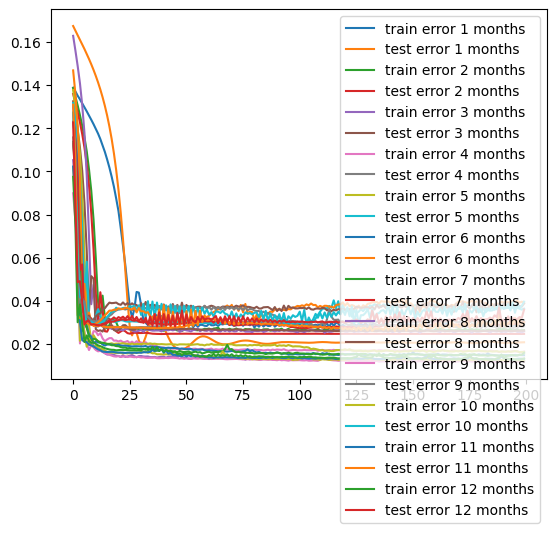

In [36]:
target_best_epochs = [0]

for i in range(len(training_months)):
    # Initialize the trainer
    training = train.Training(lstms[i+1], X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], epochs, learning_rate=learning_rate)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    lstms[i+1].load_state_dict(state_dict_list[best_epoch])
    target_best_epochs.append(best_epoch)
    
    # Save the model state dictionary for later use
    #Training.save_model(lstms[i+1], 'AUS/' + data_name + '/model_' + data_name + '_target_' + str(i+1))

In [39]:
target_RMSEs = []

# Evaluate a clean model
forecasts = lstms[0](X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = lstms[i+1](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

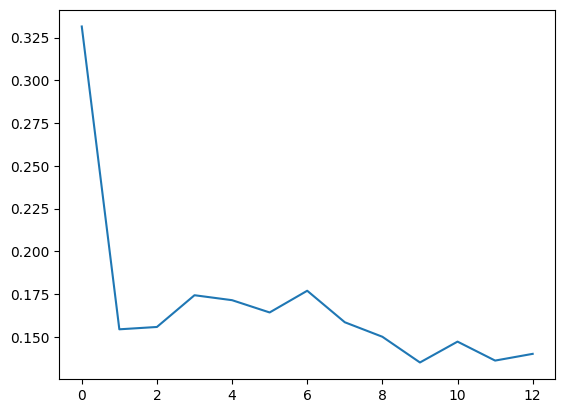

In [40]:
plt.plot(target_RMSEs)

## 7. Transfer model

In [41]:
# Layers to freeze

freezing = []

for name, _ in my_lstm.lstm.named_parameters():
    freezing.append(name)
    
freezing = freezing[:4]
freezing

['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']

Step 0: Average train loss: 0.0303 | Average test loss: 0.0217
Step 5: Average train loss: 0.0303 | Average test loss: 0.0217
Step 10: Average train loss: 0.0301 | Average test loss: 0.0218
Step 15: Average train loss: 0.0294 | Average test loss: 0.0218
Step 20: Average train loss: 0.0301 | Average test loss: 0.0218
Step 25: Average train loss: 0.0299 | Average test loss: 0.0219
Step 30: Average train loss: 0.0299 | Average test loss: 0.0219
Step 35: Average train loss: 0.0301 | Average test loss: 0.0220
Step 40: Average train loss: 0.0300 | Average test loss: 0.0220
Step 45: Average train loss: 0.0296 | Average test loss: 0.0221
Step 50: Average train loss: 0.0285 | Average test loss: 0.0221
Step 55: Average train loss: 0.0289 | Average test loss: 0.0222
Step 60: Average train loss: 0.0288 | Average test loss: 0.0223
Step 65: Average train loss: 0.0274 | Average test loss: 0.0223
Step 70: Average train loss: 0.0280 | Average test loss: 0.0224
Step 75: Average train loss: 0.0293 | Aver

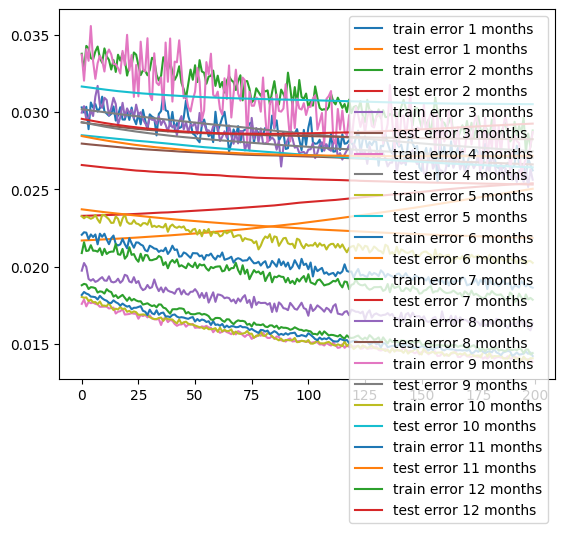

In [42]:
transfer_models = []
transfer_best_epochs = [0]

for i in range(len(training_months)):
    transfer_model  = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
    transfer_model.load_state_dict(torch.load('../models/AUS/' + data_name + '/model_' + data_name + '_transfer_0'))
       
    for name, param in transfer_model.lstm.named_parameters():
        if any(freezing_name in name for freezing_name in freezing):
            param.requires_grad = False

    # Initialize the trainer
    training = train.Training(transfer_model, X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], epochs, batch_size = batch_size, 
                              learning_rate =learning_rate/100)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    transfer_model.load_state_dict(state_dict_list[best_epoch])
    transfer_best_epochs.append(best_epoch)
    
    # Save the model state dictionary for later use
    #Training.save_model(transfer_model, 'AUS/' + data_name + '/model_' + data_name + '_transfer_' + str(i+1))
    transfer_models.append(transfer_model)

In [43]:
transfer_RMSEs = []

# Evaluate a clean model

transfer_model = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
transfer_model.load_state_dict(torch.load('../models/AUS/' + data_name + '/model_' + data_name + '_transfer_0'))

forecasts = transfer_model(X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = transfer_models[i](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

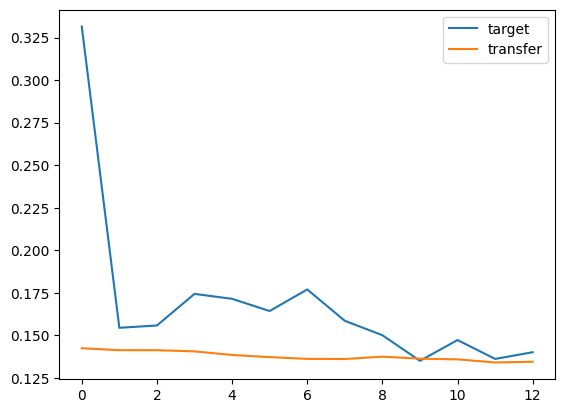

In [44]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.legend()

## 8. Baseline

In [46]:
baseline_RMSEs = []

# Evaluate a clean model
forecasts = X_eval_target_list[0][:,:,0]
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = X_eval_target_list[i][:,:,0]
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

# Final visualisation and export

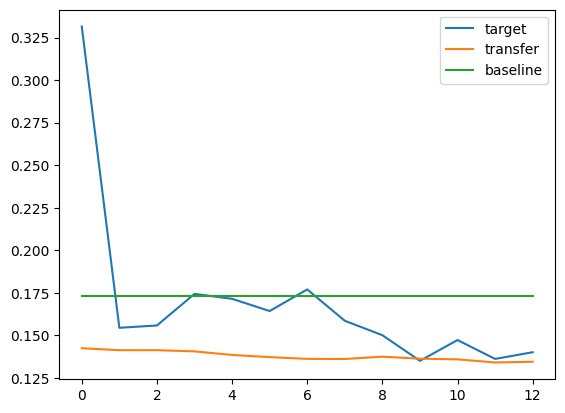

In [47]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.plot(baseline_RMSEs, label='baseline')
plt.legend()

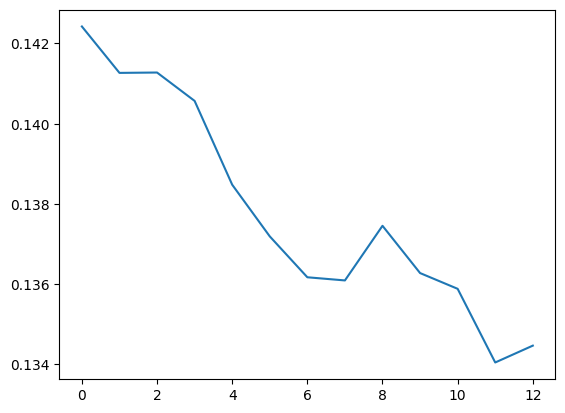

In [48]:
plt.plot(transfer_RMSEs,label='transfer')

In [49]:
column_names = []

for i in range(len(training_months)+1):
    column_names.append(str(i) + 'm')

In [50]:
all_metrics = pd.DataFrame([baseline_RMSEs, target_RMSEs, transfer_RMSEs, target_best_epochs, transfer_best_epochs],columns=column_names, index=['Baseline RMSE', 'Target RMSE', 'Transfer RMSE', 'Target epoch', 'Transfer epoch']).transpose()
all_metrics['Target epoch'] = all_metrics['Target epoch'].astype(int)
all_metrics['Transfer epoch'] = all_metrics['Transfer epoch'].astype(int)
all_metrics

,Baseline RMSE,Target RMSE,Transfer RMSE,Target epoch,Transfer epoch
0m,0.173,0.331,0.142,0,0
1m,0.173,0.154,0.141,48,0
2m,0.173,0.156,0.141,39,0
3m,0.173,0.174,0.141,13,199
4m,0.173,0.171,0.138,14,199
5m,0.173,0.164,0.137,87,199
6m,0.173,0.177,0.136,36,199
7m,0.173,0.159,0.136,101,199
8m,0.173,0.150,0.137,4,195
9m,0.173,0.135,0.136,180,199


# Comparison

In [51]:
all_metrics.to_csv('../data/AUS/' + 'summary_table_' + data_name + '.csv')

In [52]:
data_name

'australia_1'